# 0. Importing the libs and read the data

In [67]:
from pathlib import Path
import json

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

# 1. Data preparation and data cleaning

In [68]:
rows = []

for file in Path("data").glob("*.json"):
    with open(file, "r") as f:
        data = json.load(f)
        rows.append(pd.DataFrame(data["ohlcv_data"]))

df = pd.concat(rows, ignore_index=True)

In [69]:
df.dtypes

open      float64
high      float64
low       float64
close     float64
volume    float64
time       object
Volume    float64
dtype: object

In [70]:
df.head()

,open,high,low,close,volume,time,Volume
0,57.641122,57.734019,56.201208,56.294106,26094342.0,2049-05-14 17:00:00+0300,NaN
1,56.201208,56.201208,56.201208,56.201208,1416452.0,2049-05-15 09:00:00+0300,NaN
2,56.201208,56.247657,55.736720,55.968964,15677280.0,2049-05-15 10:00:00+0300,NaN
3,55.968964,56.154759,55.783169,56.015413,7296407.0,2049-05-15 11:00:00+0300,NaN
4,55.968964,56.108311,55.968964,55.968964,3602435.0,2049-05-15 12:00:00+0300,NaN


In [71]:
# Clear the UTC from the time column
df["time"] = df["time"].str.split("+").str[0]

# Rename time column to datetime
df.rename(columns={"time": "datetime"}, inplace=True)

In [72]:
# Fix volume
df["volume_fixed"] = df["volume"].combine_first(df["Volume"])

# Drop redundant colums
df = df.drop(columns=["volume", "Volume"])
df = df.rename(columns={"volume_fixed": "volume"})

In [73]:
# Make sure datetime is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Sort by datetime just in case
df = df.sort_values('datetime').reset_index(drop=True)

In [74]:
df.head()

,open,high,low,close,datetime,volume
0,10.610846,10.636802,10.532977,10.558933,2030-01-01 10:00:00,366517.0
1,10.558933,10.662758,10.558933,10.584890,2030-01-01 11:00:00,190501.0
2,10.584890,10.584890,10.584890,10.584890,2030-01-01 12:00:00,119385.0
3,10.584890,10.584890,10.584890,10.584890,2030-01-01 13:00:00,81915.0
4,10.636802,10.636802,10.558933,10.584890,2030-01-01 14:00:00,336890.0


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365700 entries, 0 to 365699
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   open      365700 non-null  float64       
 1   high      365700 non-null  float64       
 2   low       365700 non-null  float64       
 3   close     365700 non-null  float64       
 4   datetime  365700 non-null  datetime64[ns]
 5   volume    365700 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 16.7 MB


In [76]:
df.describe()

,open,high,low,close,datetime,volume
count,365700.000000,365700.000000,365700.000000,365700.000000,365700,3.657000e+05
mean,47.534699,47.754749,47.311581,47.532519,2040-06-06 17:29:01.299426048,6.198270e+06
min,0.785130,0.792165,0.778095,0.785130,2030-01-01 10:00:00,0.000000e+00
25%,9.603936,9.650013,9.559602,9.602886,2034-10-26 11:00:00,4.761068e+05
50%,20.120630,20.219279,20.021063,20.113698,2040-06-09 18:00:00,2.287868e+06
75%,62.412474,62.680366,62.127242,62.399343,2045-11-15 16:15:00,7.158064e+06
max,378.914701,380.250483,378.380388,378.914701,2051-02-21 11:00:00,2.639272e+08
std,58.467750,58.727296,58.203037,58.463612,NaN,1.102080e+07


# 2. Feature Engineering

In [77]:
# 1. Return of the previous candle
df['return_1'] = df['close'].pct_change()

# Replace NaN values resulting from pct_change
df['return_1'] = df['return_1'].fillna(0)

In [78]:
# 2. Range of the candle
df['range'] = df['high'] - df['low']

In [79]:
# 3. Body of the candle
df['body'] = (df['close'] - df['open']).abs()

In [80]:
# 4. Rolling volatility (std dev of close over last 5 candles)
df['volatility_5'] = df['close'].rolling(window=5).std()

In [81]:
# 5. Volume change
df['volume_change'] = df['volume'].pct_change()

In [82]:
# 6. Trend slope over last 5 candles (simple linear regression slope)
def rolling_slope(series, window=5):
    slopes = [np.nan] * (window-1)
    for i in range(window-1, len(series)):
        y = series[i-window+1:i+1].values
        x = np.arange(window)
        # slope = cov(x, y)/var(x)
        slope = np.polyfit(x, y, 1)[0]
        slopes.append(slope)
    return slopes

df['trend_slope_5'] = rolling_slope(df['close'], window=5)

In [83]:
# -------------------------
# Targets
# -------------------------
horizon = 10  # look 10 candles ahead

# 1. Classification target: 1 if price goes up in 10 candles, else 0
df['y_class'] = (df['close'].shift(-horizon) > df['close']).astype(int)

# 2. Regression target: future close price
df['y_reg'] = df['close'].shift(-horizon)

In [84]:
df.isnull().sum()

open              0
high              0
low               0
close             0
datetime          0
volume            0
return_1          0
range             0
body              0
volatility_5      4
volume_change     6
trend_slope_5     4
y_class           0
y_reg            10
dtype: int64

In [85]:
df.shape

(365700, 14)

In [86]:
df = df.dropna().reset_index(drop=True)

In [87]:
df.shape

(365681, 14)

In [88]:
print(f"There where {365700 - 365681} rows dropped due to NaN values.")

There where 19 rows dropped due to NaN values.


In [89]:
df.head().T

,0,1,2,3,4
open,10.636802,10.58489,10.558933,10.481065,10.455109
high,10.636802,10.610846,10.610846,10.481065,10.455109
low,10.558933,10.558933,10.481065,10.351285,10.403197
close,10.58489,10.558933,10.481065,10.455109,10.403197
datetime,2030-01-01 14:00:00,2030-01-01 15:00:00,2030-01-01 16:00:00,2030-01-01 17:00:00,2030-01-02 09:00:00
volume,336890.0,214840.0,312632.0,295485.0,152509.0
return_1,0.0,-0.002452,-0.007375,-0.002476,-0.004965
range,0.077868,0.051912,0.12978,0.12978,0.051912
body,0.051912,0.025956,0.077868,0.025956,0.051912
volatility_5,0.011608,0.011608,0.044957,0.060872,0.074779


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365681 entries, 0 to 365680
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   open           365681 non-null  float64       
 1   high           365681 non-null  float64       
 2   low            365681 non-null  float64       
 3   close          365681 non-null  float64       
 4   datetime       365681 non-null  datetime64[ns]
 5   volume         365681 non-null  float64       
 6   return_1       365681 non-null  float64       
 7   range          365681 non-null  float64       
 8   body           365681 non-null  float64       
 9   volatility_5   365681 non-null  float64       
 10  volume_change  365681 non-null  float64       
 11  trend_slope_5  365681 non-null  float64       
 12  y_class        365681 non-null  int64         
 13  y_reg          365681 non-null  float64       
dtypes: datetime64[ns](1), float64(12), int64(1)
memory u

In [91]:
df.dtypes

open                    float64
high                    float64
low                     float64
close                   float64
datetime         datetime64[ns]
volume                  float64
return_1                float64
range                   float64
body                    float64
volatility_5            float64
volume_change           float64
trend_slope_5           float64
y_class                   int64
y_reg                   float64
dtype: object

In [92]:
df.describe().T

/Users/alexandru.huc/Downloads/Development/GitHub/OHLCV-stock-analysis/OHLCV_venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,min,25%,50%,75%,max,std
open,365681.0,47.536525,0.78513,9.604239,20.121241,62.412474,378.914701,58.468651
high,365681.0,47.756585,0.792165,9.650426,20.219799,62.686178,380.250483,58.7282
low,365681.0,47.313397,0.778095,9.559887,20.021939,62.133691,378.380388,58.203935
close,365681.0,47.534345,0.78513,9.603898,20.114963,62.405694,378.914701,58.464513
datetime,365681,2040-06-06 16:04:06.194907904,2030-01-01 14:00:00,2034-10-26 11:00:00,2040-06-09 17:00:00,2045-11-15 15:00:00,2051-02-18 10:00:00,NaN
volume,365681.0,6197377.860731,0.0,476144.0,2287848.0,7157543.0,263927184.0,11018773.131977
return_1,365681.0,2.396217,-0.995167,-0.65167,0.0,1.86894,204.498411,7.767469
range,365681.0,0.443188,0.0,0.051558,0.1369,0.486635,19.863395,0.779223
body,365681.0,0.210165,0.0,0.0121,0.052915,0.186466,12.188021,0.467073
volatility_5,365681.0,45.407388,0.0,18.081288,41.063605,65.741063,198.419214,32.475491


# 3. Exploratory Data Analysis

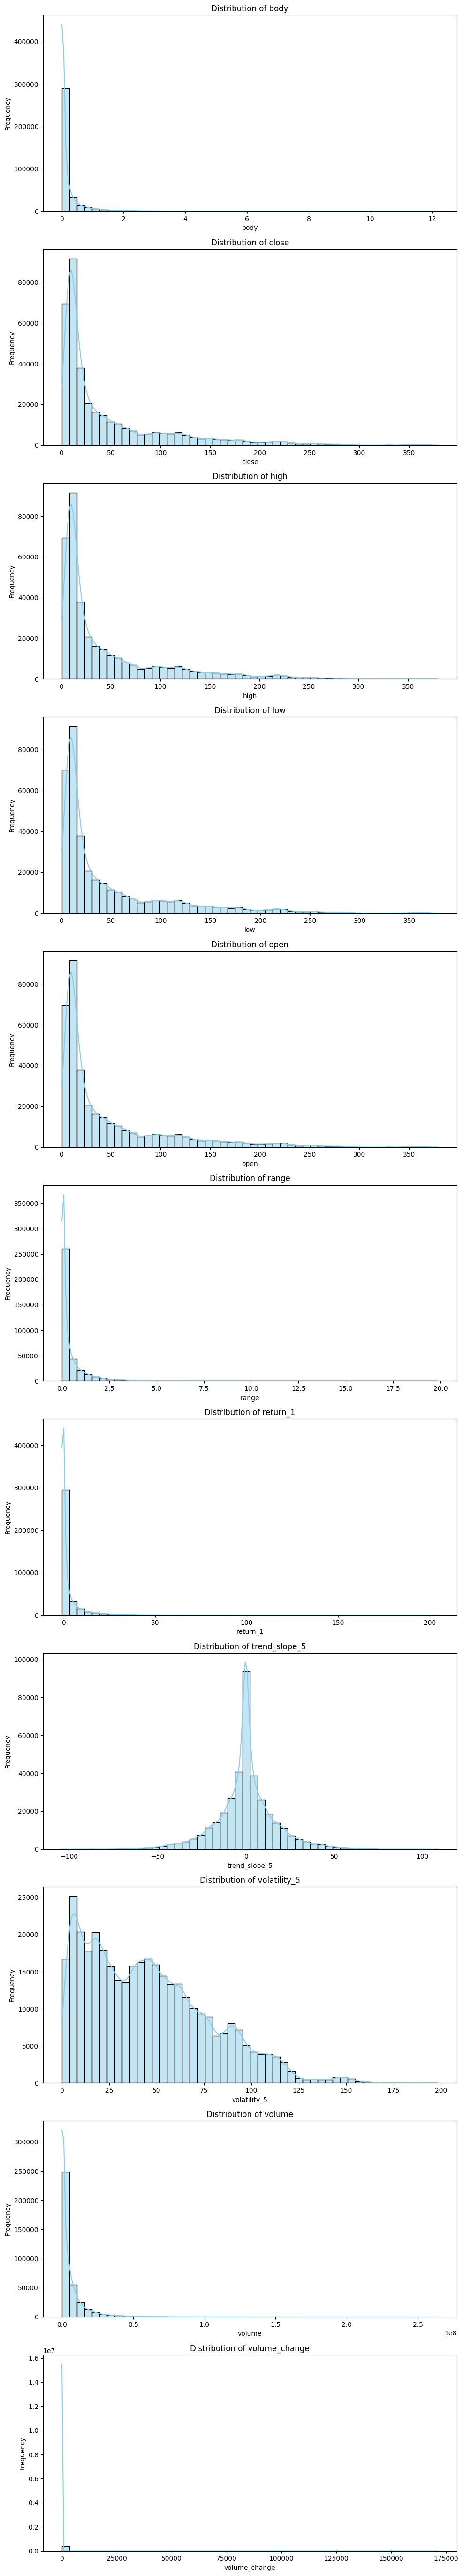

In [93]:
# Select only numeric columns excluding the targets
cols_to_plot = df.select_dtypes(include=['float64', 'int64']).columns.difference(['y_class', 'y_reg'])

# Set up the figure
plt.figure(figsize=(10, 5 * len(cols_to_plot)))  # make height proportional to number of columns

# Loop over columns and create a subplot for each
for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(len(cols_to_plot), 1, i)  # vertical stack
    sns.histplot(df[col], bins=50, kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

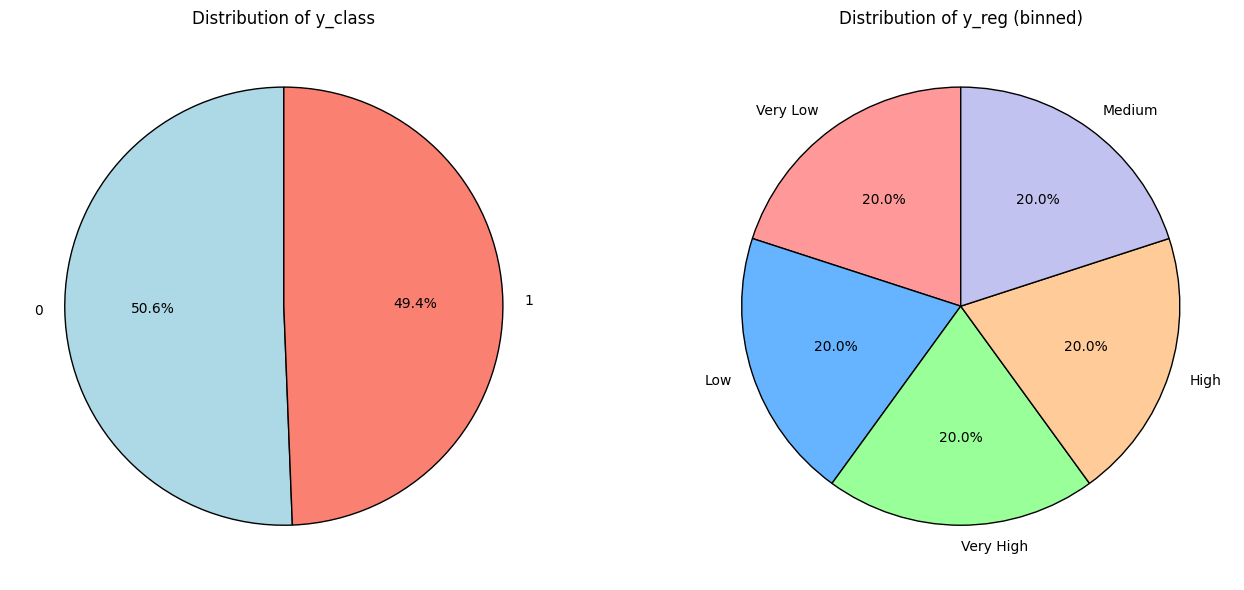

In [94]:
# --- Pie chart data ---
y_class_counts = df['y_class'].value_counts()

# Create 5 bins for y_reg
df['y_reg_bin'] = pd.qcut(df['y_reg'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
y_reg_counts = df['y_reg_bin'].value_counts()

# Define custom colors
y_class_colors = ['lightblue', 'salmon']
y_reg_colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']

# --- Plot side by side ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart for y_class
axes[0].pie(y_class_counts, labels=y_class_counts.index, autopct='%1.1f%%', startangle=90, colors=y_class_colors, wedgeprops={'edgecolor':'black'})
axes[0].set_title('Distribution of y_class')

# Pie chart for y_reg (binned)
axes[1].pie(y_reg_counts, labels=y_reg_counts.index, autopct='%1.1f%%', startangle=90, colors=y_reg_colors, wedgeprops={'edgecolor':'black'})
axes[1].set_title('Distribution of y_reg (binned)')

plt.tight_layout()
plt.show()

In [95]:
df = df.drop(columns=['y_reg_bin'])

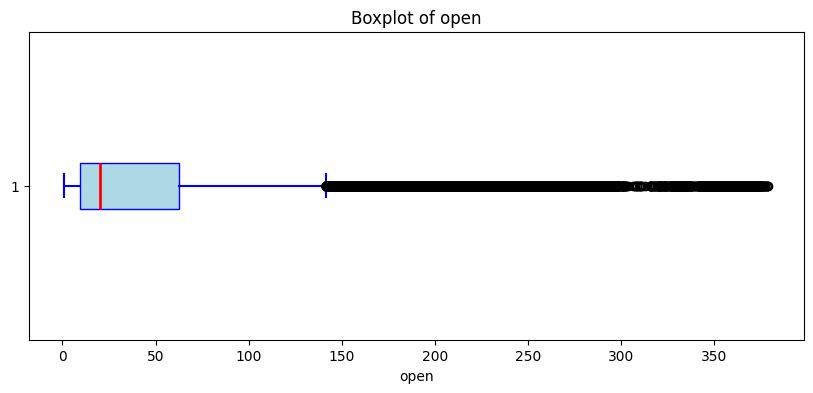

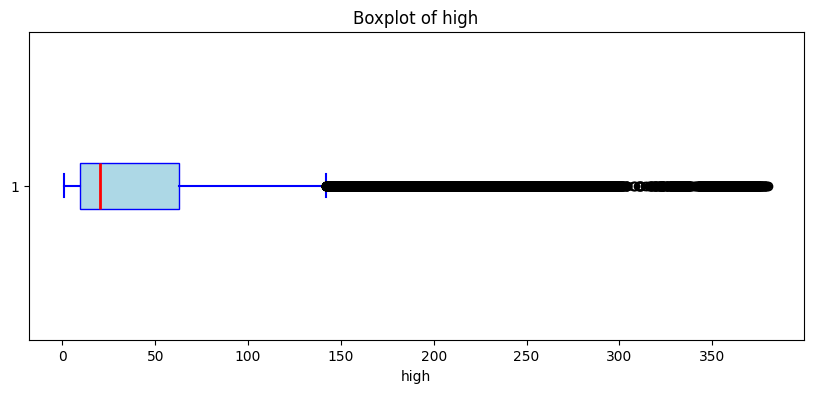

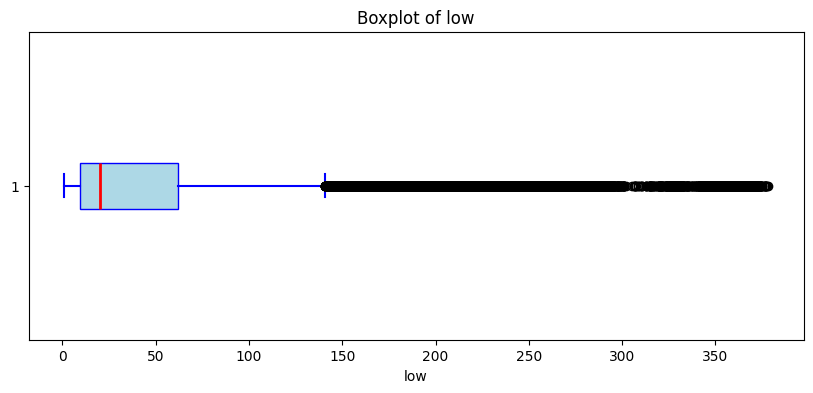

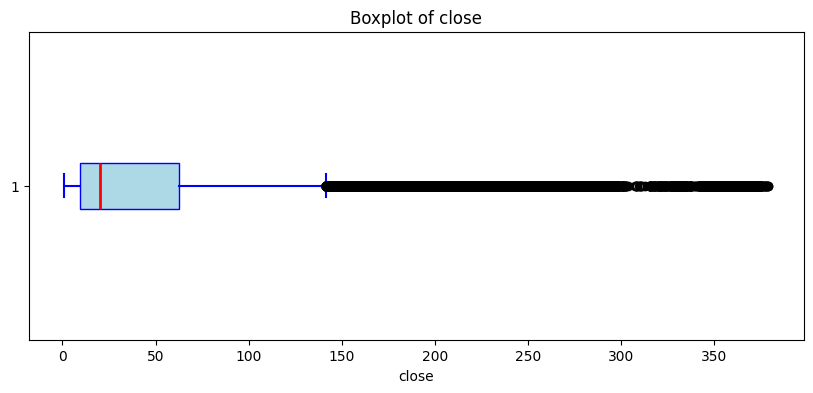

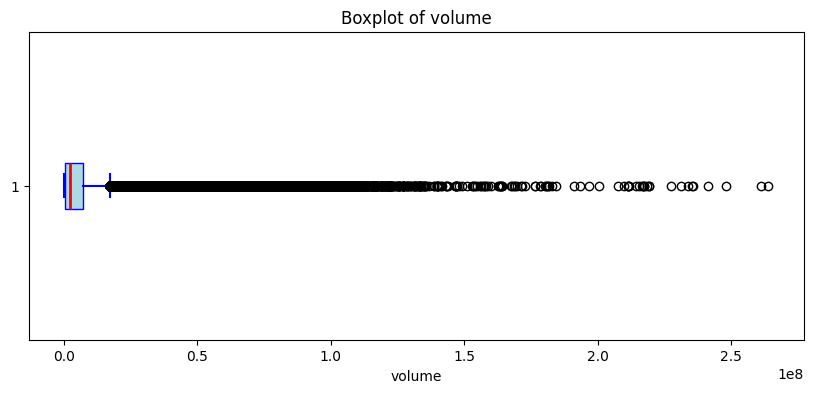

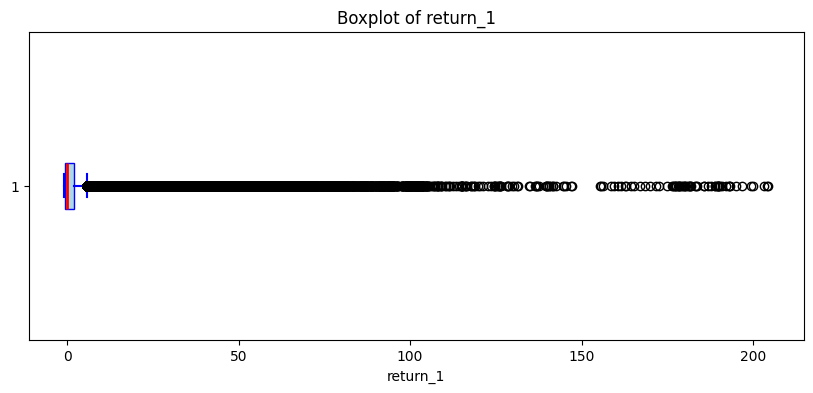

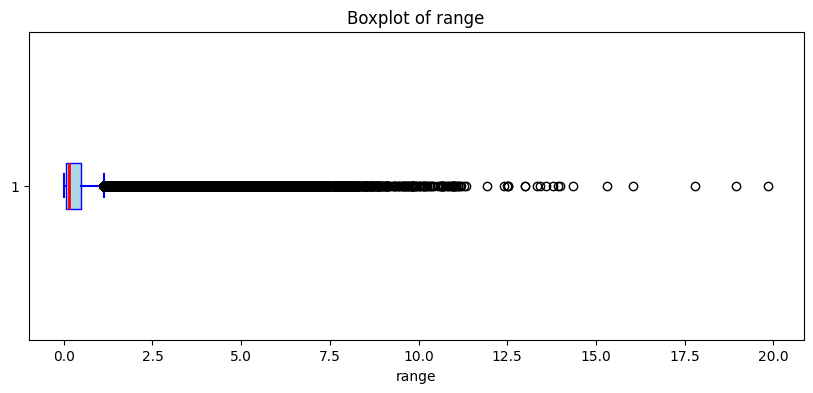

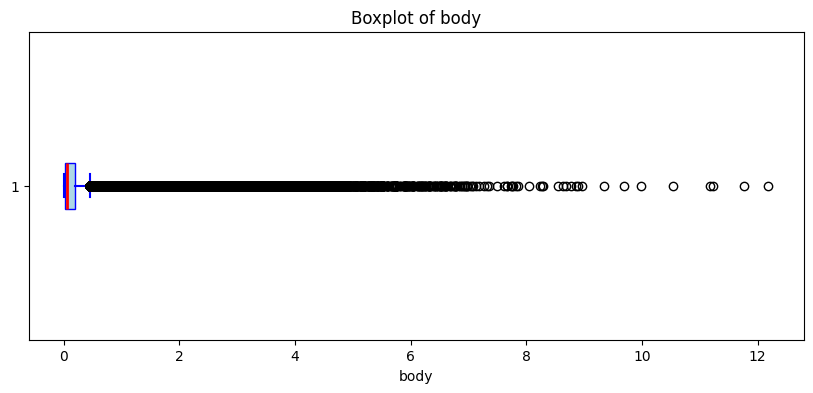

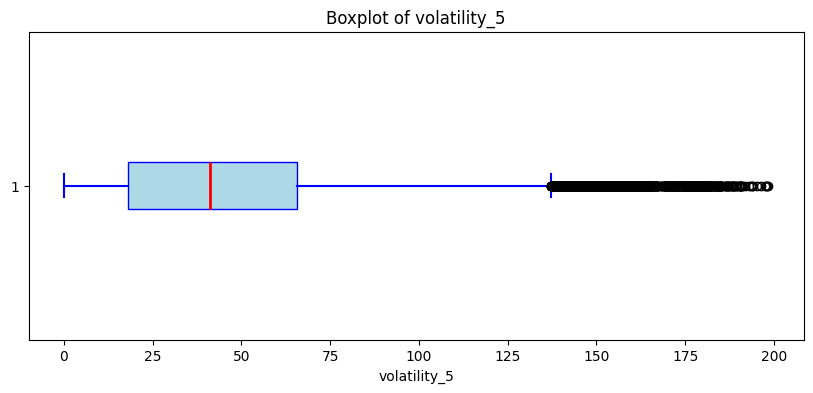

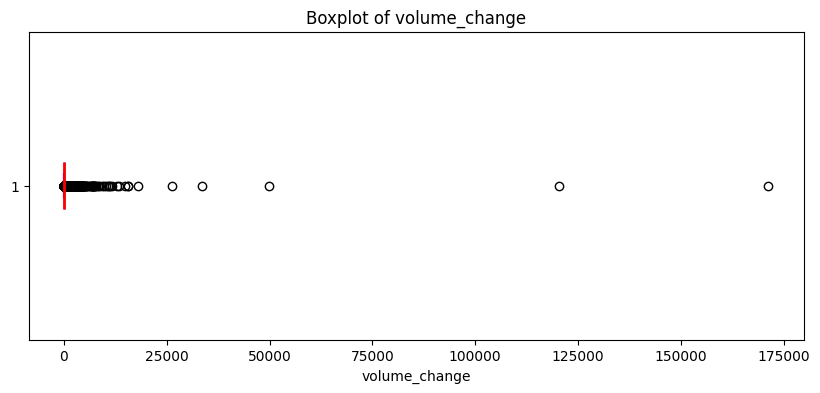

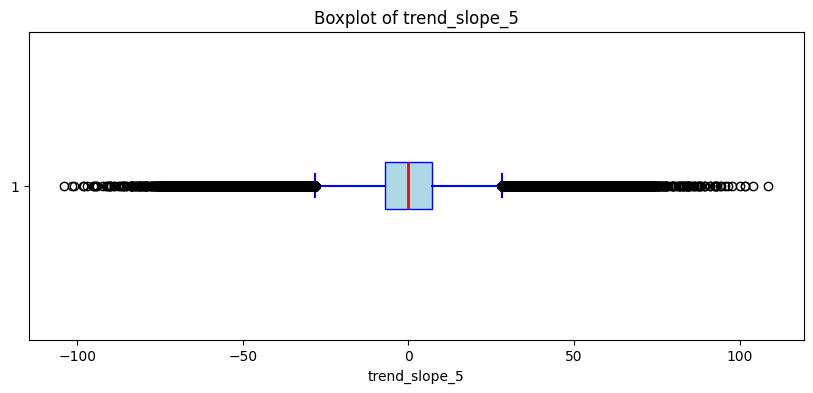

In [96]:
# Select numeric columns only, exclude y_class, y_reg, y_reg_bin
columns_to_plot = df.select_dtypes(include=['float64', 'int64']).columns
columns_to_plot = [col for col in columns_to_plot if col not in ['y_class', 'y_reg']]

# Create boxplots for each column
for col in columns_to_plot:
    plt.figure(figsize=(10, 4))
    plt.boxplot(df[col], vert=False, patch_artist=True, 
                boxprops=dict(facecolor='lightblue', color='blue'),
                whiskerprops=dict(color='blue', linewidth=1.5),
                capprops=dict(color='blue', linewidth=1.5),
                medianprops=dict(color='red', linewidth=2))
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

## Price Evolution

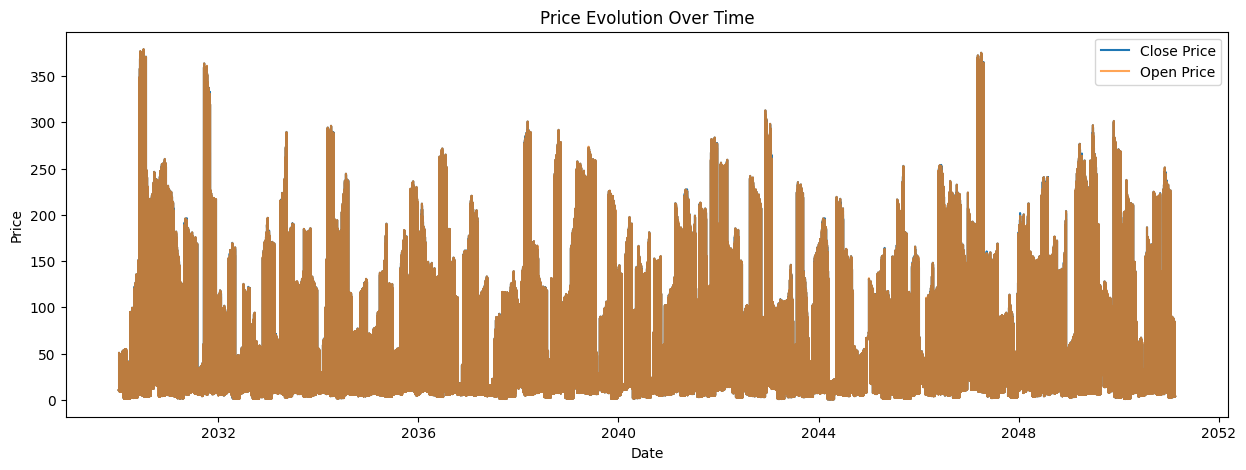

In [97]:
plt.figure(figsize=(15,5))
plt.plot(df['datetime'], df['close'], label='Close Price')
plt.plot(df['datetime'], df['open'], label='Open Price', alpha=0.7)
plt.title('Price Evolution Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Volume over time

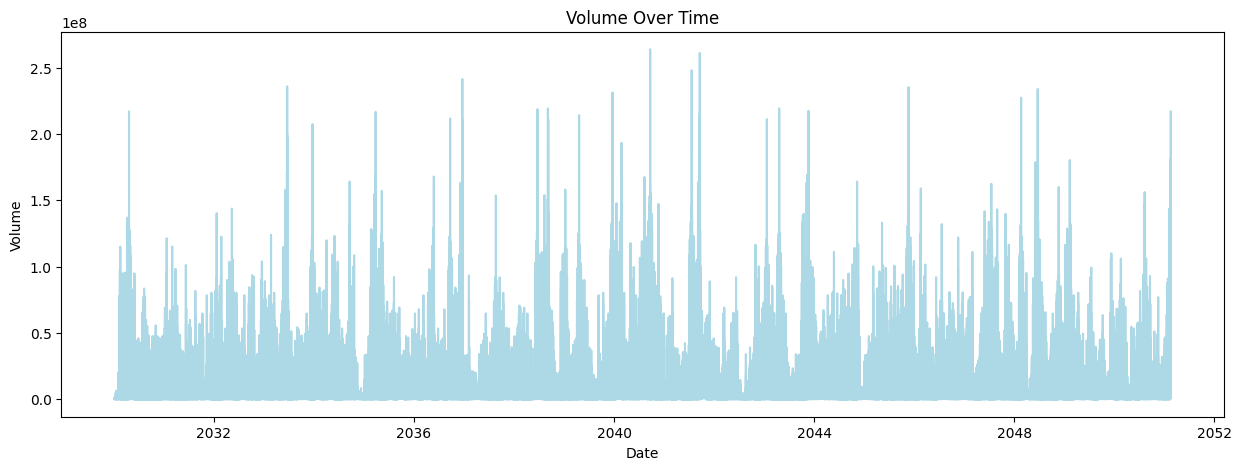

In [98]:
plt.figure(figsize=(15,5))
plt.plot(df['datetime'], df['volume'], color='lightblue')
plt.title('Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()


## Rolling volatility / trend slope

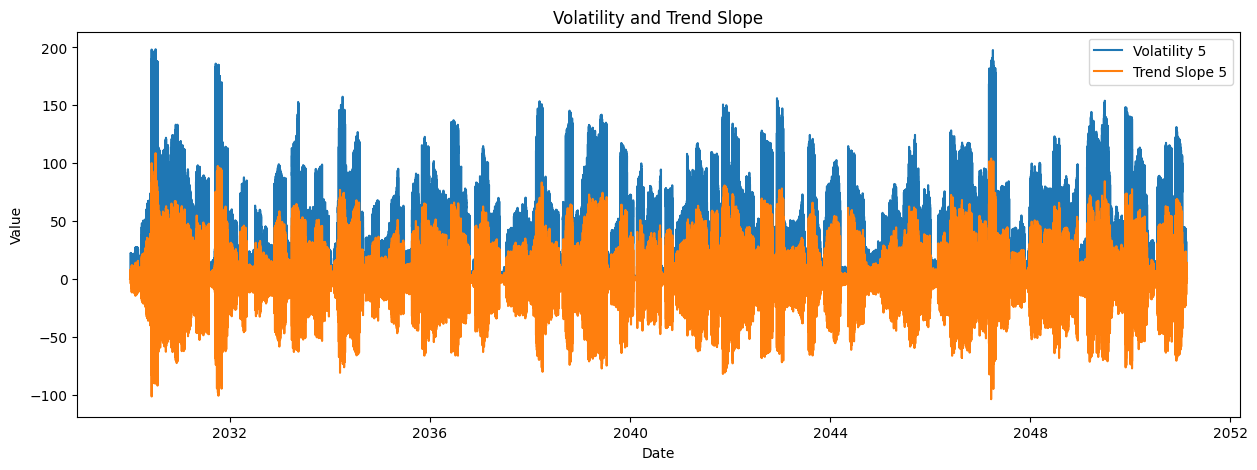

In [99]:
plt.figure(figsize=(15,5))
plt.plot(df['datetime'], df['volatility_5'], label='Volatility 5')
plt.plot(df['datetime'], df['trend_slope_5'], label='Trend Slope 5')
plt.title('Volatility and Trend Slope')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

## Pairplots / Scatterplots

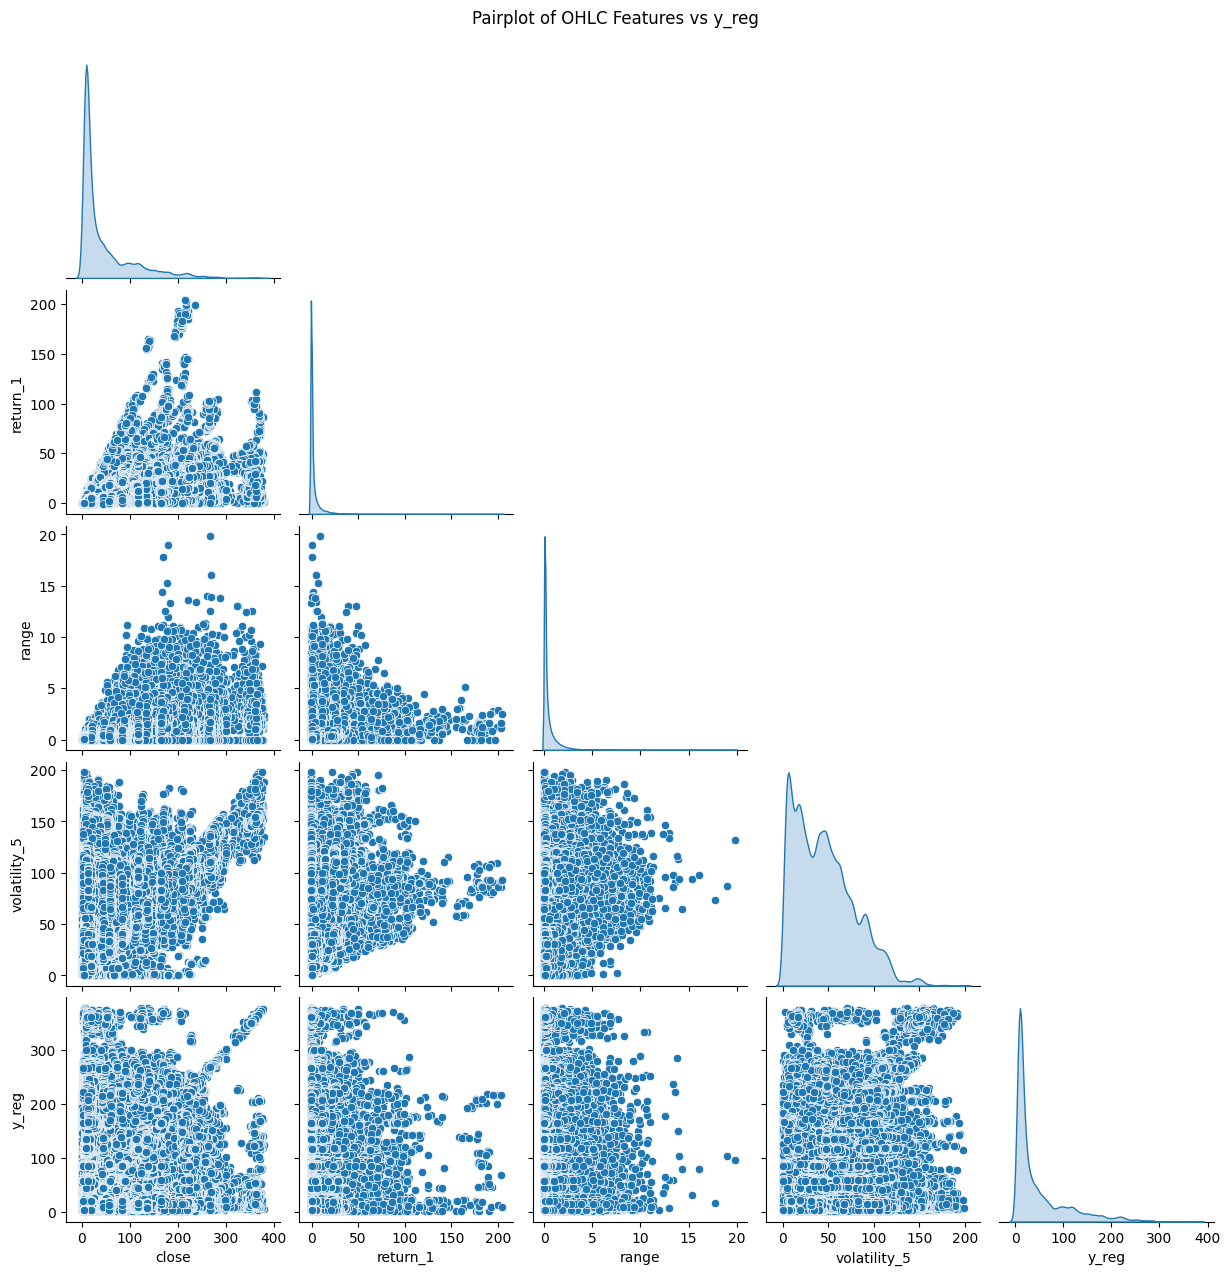

In [100]:
# Pairplot of selected columns
sns.pairplot(
    df[['close','return_1','range','volatility_5','y_reg']], 
    diag_kind='kde',  # Kernel Density Estimation for histograms on the diagonal
    corner=True        # Only shows lower triangle (no duplicate plots)
)
plt.suptitle('Pairplot of OHLC Features vs y_reg', y=1.02)
plt.show()

## Rolling Statistics

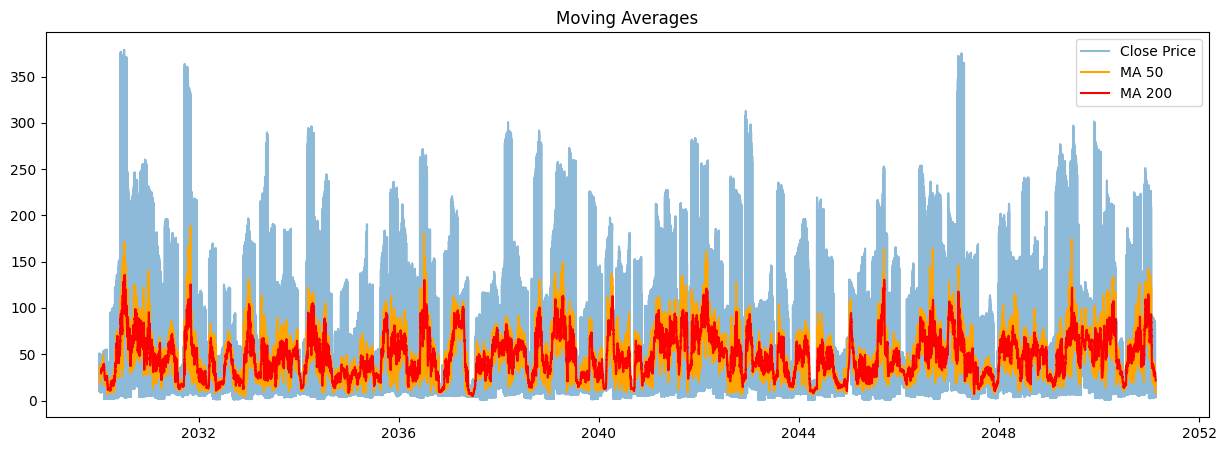

In [101]:
plt.figure(figsize=(15,5))
plt.plot(df['datetime'], df['close'], label='Close Price', alpha=0.5)
plt.plot(df['datetime'], df['close'].rolling(window=50).mean(), label='MA 50', color='orange')
plt.plot(df['datetime'], df['close'].rolling(window=200).mean(), label='MA 200', color='red')
plt.title('Moving Averages')
plt.legend()
plt.show()

## Correlation Heatmap

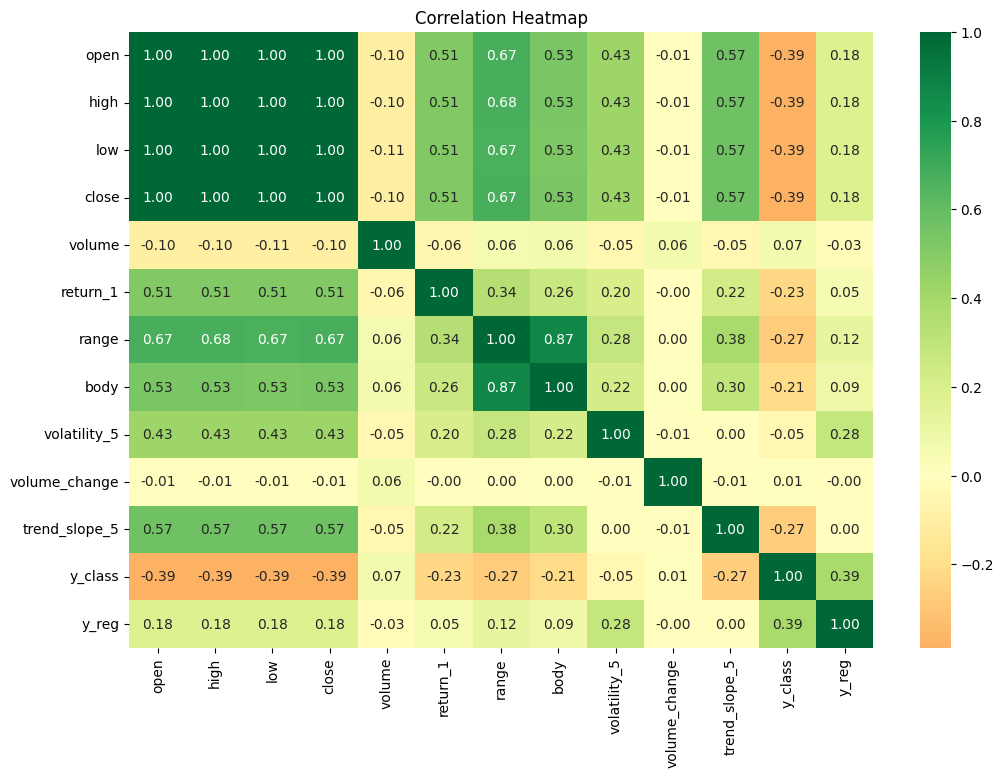

In [102]:
plt.figure(figsize=(12,8))

corr = df.select_dtypes(include='number').corr()

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn", # red -> yellow -> green
    center=0       # 0 = neutral (yellow)
)

plt.title("Correlation Heatmap")
plt.show()

# 4. Feature and Target Selection

In [103]:
# Classification Target
classification_target = 'y_class'
target_classification = [classification_target]

# Regression Target
regression_target = 'y_reg'
target_regression = [regression_target]

# Classification Features: all features except the target column for classification
classification_features = df.drop(columns=[classification_target, regression_target, 'datetime'])

# Regression Features: all features except the target column for regression
regression_features = df.drop(columns=[regression_target, classification_target, 'datetime'])


In [104]:
print("Classification Features:")
print(list(classification_features.columns))

Classification Features:
['open', 'high', 'low', 'close', 'volume', 'return_1', 'range', 'body', 'volatility_5', 'volume_change', 'trend_slope_5']


In [105]:
print("\nClassification Target:")
print(classification_target)


Classification Target:
y_class


In [106]:
print("\nRegression Features:")
print(list(regression_features.columns))


Regression Features:
['open', 'high', 'low', 'close', 'volume', 'return_1', 'range', 'body', 'volatility_5', 'volume_change', 'trend_slope_5']


In [107]:
print("\nRegression Target:")
print(regression_target)


Regression Target:
y_reg


# 5. Split the data - Regression & Classification

- Split the data in train/val/test sets with 60%/20%/20% distribution.

In [108]:
# ---------------------- CLASSIFICATION SPLIT ----------------------

# Prepare the classification data (features + target)
df_classification = df[classification_features.columns.tolist() + target_classification]

# Split the data into training, validation, and test sets
df_class_full_train, df_class_test = train_test_split(df_classification, test_size=0.2, random_state=1)
df_class_train, df_class_val = train_test_split(df_class_full_train, test_size=0.25, random_state=1)

# Reset indices
df_class_train = df_class_train.reset_index(drop=True)
df_class_val = df_class_val.reset_index(drop=True)
df_class_test = df_class_test.reset_index(drop=True)

# Extract target variables (y_class)
y_class_train = df_class_train[classification_target].values
y_class_val = df_class_val[classification_target].values
y_class_test = df_class_test[classification_target].values

# Drop the target variable from the DataFrames
del df_class_train[classification_target]
del df_class_val[classification_target]
del df_class_test[classification_target]

# Print dataset sizes
print('Training set size:', len(df_class_train), f"{round(len(df_class_train) / (len(df_class_train) + len(df_class_val) + len(df_class_test)), 2)}")
print('Validation set size:', len(df_class_val), f"{round(len(df_class_val) / (len(df_class_train) + len(df_class_val) + len(df_class_test)), 2)}")
print('Test set size:', len(df_class_test), f"{round(len(df_class_test) / (len(df_class_train) + len(df_class_val) + len(df_class_test)), 2)}")

Training set size: 219408 0.6
Validation set size: 73136 0.2
Test set size: 73137 0.2


In [109]:
# Convert DataFrames to dictionaries
df_class_train_dicts = df_class_train.to_dict(orient='records')
df_class_val_dicts = df_class_val.to_dict(orient='records')
df_class_test_dicts = df_class_test.to_dict(orient='records')

In [110]:
# Vectorize the data
dv = DictVectorizer(sparse=True)
X_class_train = dv.fit_transform(df_class_train_dicts)
X_class_val = dv.transform(df_class_val_dicts)
X_class_test = dv.transform(df_class_test_dicts)

In [111]:
# ---------------------- REGRESSION SPLIT ----------------------

# Prepare the regression data (features + target)
df_regression = df[regression_features.columns.tolist() + target_regression]

# Split the data into training, validation, and test sets
df_reg_full_train, df_reg_test = train_test_split(df_regression, test_size=0.2, random_state=1)
df_reg_train, df_reg_val = train_test_split(df_reg_full_train, test_size=0.25, random_state=1)

# Reset indices
df_reg_train = df_reg_train.reset_index(drop=True)
df_reg_val = df_reg_val.reset_index(drop=True)
df_reg_test = df_reg_test.reset_index(drop=True)

# Extract target variables (y_reg)
y_reg_train = df_reg_train[regression_target].values
y_reg_val = df_reg_val[regression_target].values
y_reg_test = df_reg_test[regression_target].values

# Drop the target variable from the DataFrames
del df_reg_train[regression_target]
del df_reg_val[regression_target]
del df_reg_test[regression_target]

print('Training set size:', len(df_reg_train), f"{round(len(df_reg_train) / (len(df_reg_train) + len(df_reg_val) + len(df_reg_test)), 2)}")
print('Validation set size:', len(df_reg_val), f"{round(len(df_reg_val) / (len(df_reg_train) + len(df_reg_val) + len(df_reg_test)), 2)}")
print('Test set size:', len(df_reg_test), f"{round(len(df_reg_test) / (len(df_reg_train) + len(df_reg_val) + len(df_reg_test)), 2)}")

Training set size: 219408 0.6
Validation set size: 73136 0.2
Test set size: 73137 0.2


In [112]:
# Convert DataFrames to dictionaries
df_reg_train_dicts = df_reg_train.to_dict(orient='records')
df_reg_val_dicts = df_reg_val.to_dict(orient='records')
df_reg_test_dicts = df_reg_test.to_dict(orient='records')

In [113]:
# Vectorize the data
X_reg_train = dv.fit_transform(df_reg_train_dicts)
X_reg_val = dv.transform(df_reg_val_dicts)
X_reg_test = dv.transform(df_reg_test_dicts)

# 6. Classification Model Process